# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

# Step 1: Read in Data

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression


df = pd.read_csv('Resources/kc_house_data_train.csv', index_col=0)
df = df.drop(['id'], axis=1)

In [2]:
#adjusting bedrooms outliers 
df['bedrooms'] = df['bedrooms'].apply(lambda x : 9 if x > 9 else x)
#np.where(df['my_channel'] > 20000, 0, df['my_channel'])

In [3]:
#Run below cell for heatmap of correlations

In [4]:
# #create a heatmap to visualize the correlations
# fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
# corr = df.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# # fix for matplotlib bug that cuts off top/bottom of seaborn viz
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values

# plt.show()

# Step 2: EDA
### Initial Findings and planning
- **highest correlations:** 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15' (check for outliers and extreme values)
    - sqft_living seems like a better predictor
- **suprisingly low correlations:** 'bedrooms', 'waterfront', 'view', 'condition', 'renovated_0' (manipulate to create higher correlations)
- check out for outliers in price by sqft
- 33 bedrooms outlier
- bin `condition` into 3 categories: 1/2, 3/4, and 5
- bin `view` into 3 categories: 0, 1&2, 3, 4 (create poly?)
- `grade` poly?
- dummy code zip codes
- check out distances from Seattle city center with `lat` and `long`
- viz for floors
- waterfront: t-test

In [5]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [6]:
#changing date format workable month/year

#df['yr_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.year
df['month_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.month
df.drop('date',axis=1,inplace=True)

In [7]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold
0,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,10
1,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,8
2,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,8
3,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,3
4,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,7


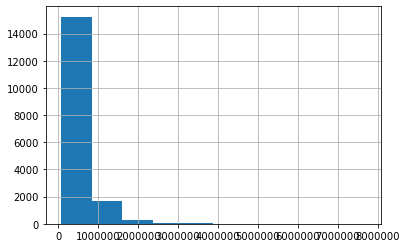

In [8]:
df.price.hist()

**almost normal: price by sqft, sqft_living, yr_built**

In [9]:
#log:sqft_above, sqft_living, sqft_living15, 

In [10]:
# Run below cell for histograms

In [11]:
# df.hist(bins=50, figsize=(20,15))
# plt.show()

Bin groups: Condition (1&2, 3&4, 5); View (0, 1&2, 3&4)

polynomial grade,  `df['grade_exp'] = np.exp(df['grade'])`, view(?)

waterfront: t-test

In [12]:
#Run below cell for pairplot

In [13]:
# sns.pairplot(df[['bathrooms', 'bedrooms', 'lat', 'long', 'month_sold', 'sqft_above', 'sqft_basement', 'sqft_living', 'grade', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'yr_built', 'yr_renovated', 'price']], corner=True)


In [14]:
# # Bar plots of categorical data
# #zipcode explored later
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

# categoricals = ['condition', 'floors', 'grade', 'month_sold', 'yr_sold', 'view', 'waterfront']

# for col, ax in zip(categoricals, axes.flatten()):
#     (df.groupby(col)               # group values together by column of interest
#          .mean()['price']        # take the mean of the saleprice for each group
#          .plot
#          .bar(ax=ax))                # create a bar graph on the ax    
#     ax.set_title(col)                # Make the title the name of the column
# fig.tight_layout()

# Investigation

### Outcome Variable: Price
may keep `price` as-is -- perhaps bring outliers down to 6000000? Let's see how models do with both options

NOTE: may help to normalize/scale/log

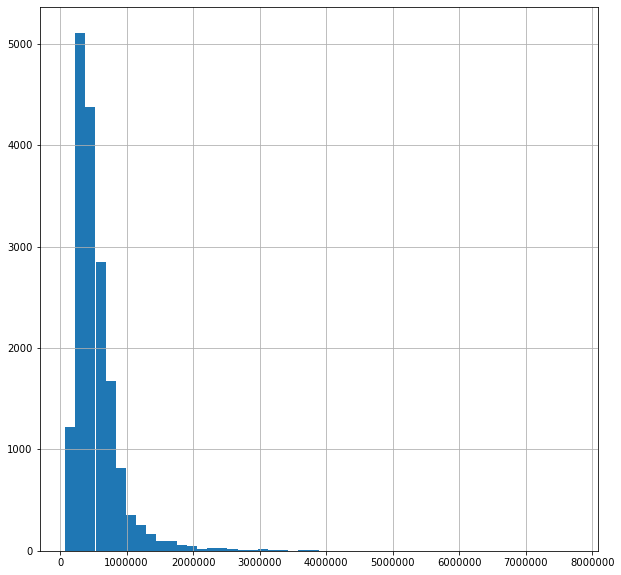

In [19]:
# Take the Log of price to normalize
df.price.hist(bins=50, figsize=(10,10))
plt.show()

#### Price by square feet (checking for outliers)

In [20]:
## Creating new feature: price per square feet
df['price_by_sqft'] = df.price/df.sqft_living
df.sort_values('price_by_sqft').head()

In [24]:
df = df.drop(['price_by_sqft'], axis=1)

## Zipcode 
create dummy codes in feature creation

In [25]:
df.zipcode.value_counts().count()

70

In [26]:
#DF of price and zipcode
df[['price', 'zipcode']].sort_values('price')

## Next step: get mean of price for each zipcode

,price,zipcode
9060,75000.0,98022
4869,78000.0,98168
9193,80000.0,98014
15956,82000.0,98146
1269,82500.0,98168
...,...,...
1979,5350000.0,98004
2232,5570000.0,98039
7519,6885000.0,98039
6903,7062500.0,98004


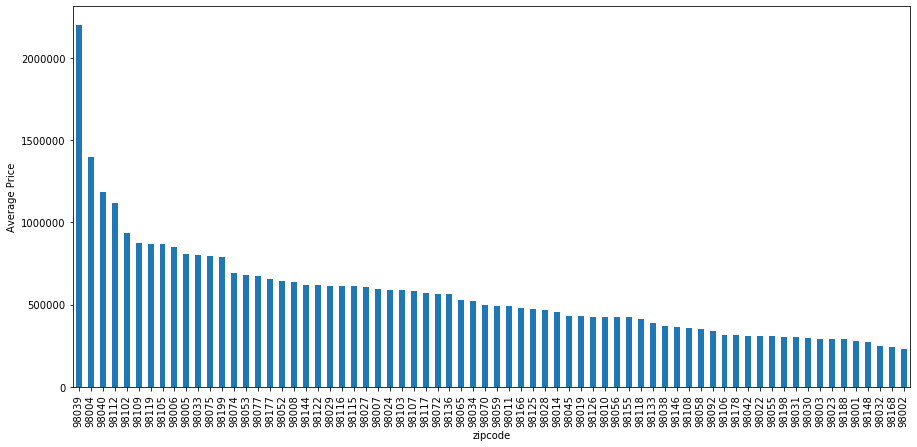

In [27]:
zip_means = df.groupby(['zipcode']).price.mean().sort_values(ascending=False)
plt.figure(figsize=(15,7))
plt.ylabel('Average Price')
zip_means.plot(kind='bar')

## Floors

Text(0.5, 0, 'Floors')

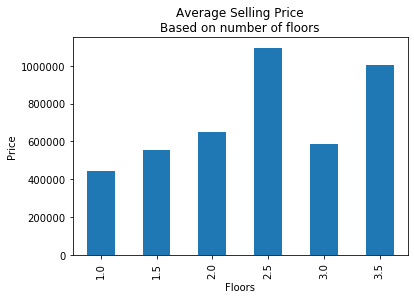

In [28]:
#Barplot Price v number of floors
df.groupby('floors')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on number of floors', size=12)
plt.ylabel('Price')
plt.xlabel('Floors')

In [29]:
df['floors_x_sqft_living'] = df['floors']*df['sqft_living']


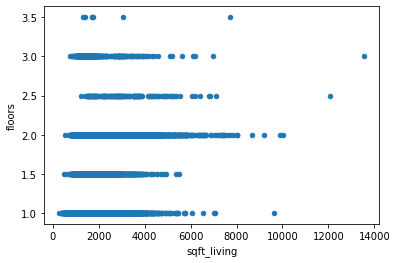

In [30]:
df.plot(kind='scatter', x='sqft_living', y='floors')

In [31]:
#df = df.drop(['floors_x_sqft_living'], axis=1)

## Strong correlations (plots)
- cap square foot living
- Checking for outliers and trends in grade, bathrooms, sqft_living, sqft_above, sqft_living15

In [32]:
cols = ['bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']
#break the colums in to groups to plot 4 on a row at a time
n = 5
row_groups= [cols[i:i+n] for i in range(0, len(cols), n) ]

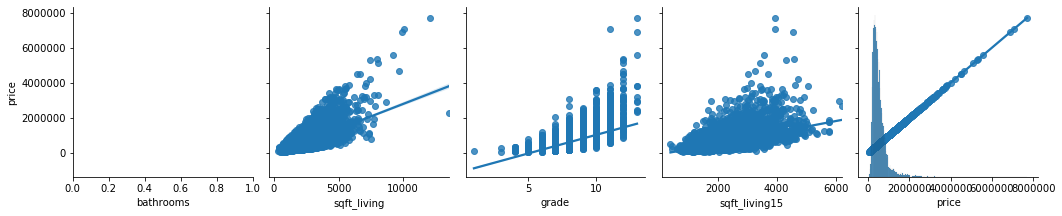

In [33]:
for i in row_groups:
    pp = sns.pairplot(data=df[cols], y_vars='price',x_vars=i, kind="reg", height=3)

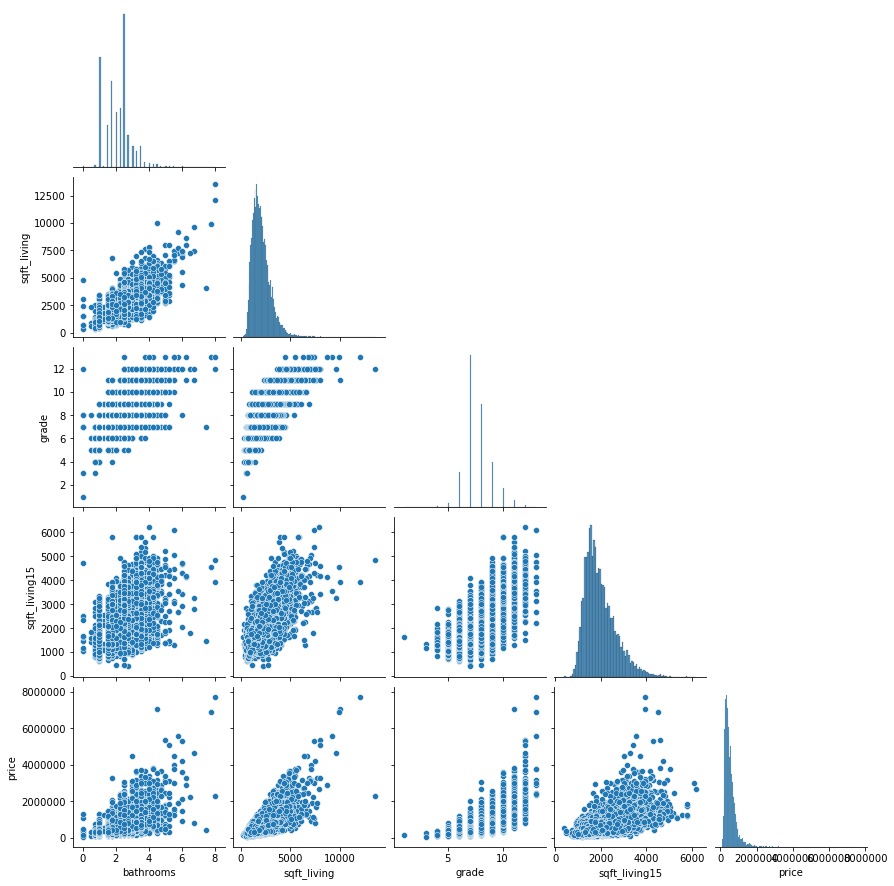

In [34]:
sns.pairplot(df[['bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']], corner=True)

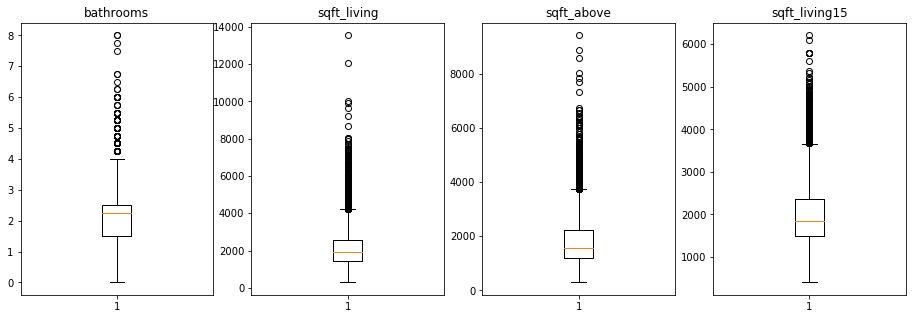

In [35]:
plt.figure(figsize=(20,5))

# ax3 = plt.subplot(1, 5, 1)
# plt.boxplot(df.grade)
# ax3.set_title('grade')

ax1 = plt.subplot(1, 5, 2)
plt.boxplot(df.bathrooms)
ax1.set_title('bathrooms')

ax2 = plt.subplot(1, 5, 3)
plt.boxplot(df.sqft_living)
ax2.set_title('sqft_living')


ax3 = plt.subplot(1, 5, 4)
plt.boxplot(df.sqft_above)
ax3.set_title('sqft_above')

ax3 = plt.subplot(1, 5, 5)
plt.boxplot(df.sqft_living15)
ax3.set_title('sqft_living15')

plt.show()

### 1. Bathrooms

Text(0.5, 0, 'Bathrooms')

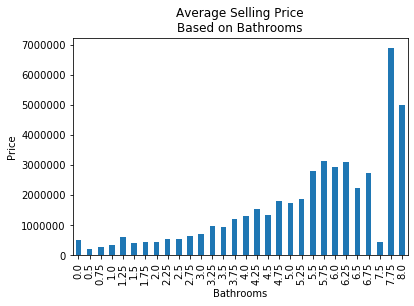

In [36]:
#Barplot Price v Bathrooms
df.groupby('bathrooms')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on Bathrooms', size=12)
plt.ylabel('Price')
plt.xlabel('Bathrooms')

In [37]:
# #Run model without this parameter first
# df['bathrooms'] = np.where(df.bathrooms>6, 6, df['bathrooms'])

In [38]:
df.bathrooms.value_counts()

2.50    4322
1.00    3100
1.75    2431
2.25    1666
2.00    1549
1.50    1168
2.75     896
3.00     592
3.50     591
3.25     455
3.75     135
4.00     107
4.50      76
4.25      64
0.75      52
5.00      17
4.75      16
5.25      11
0.00       8
5.50       7
1.25       6
6.00       6
5.75       3
0.50       3
8.00       2
6.75       2
6.25       2
7.50       1
6.50       1
7.75       1
Name: bathrooms, dtype: int64

Text(0.5, 0, 'Bathrooms')

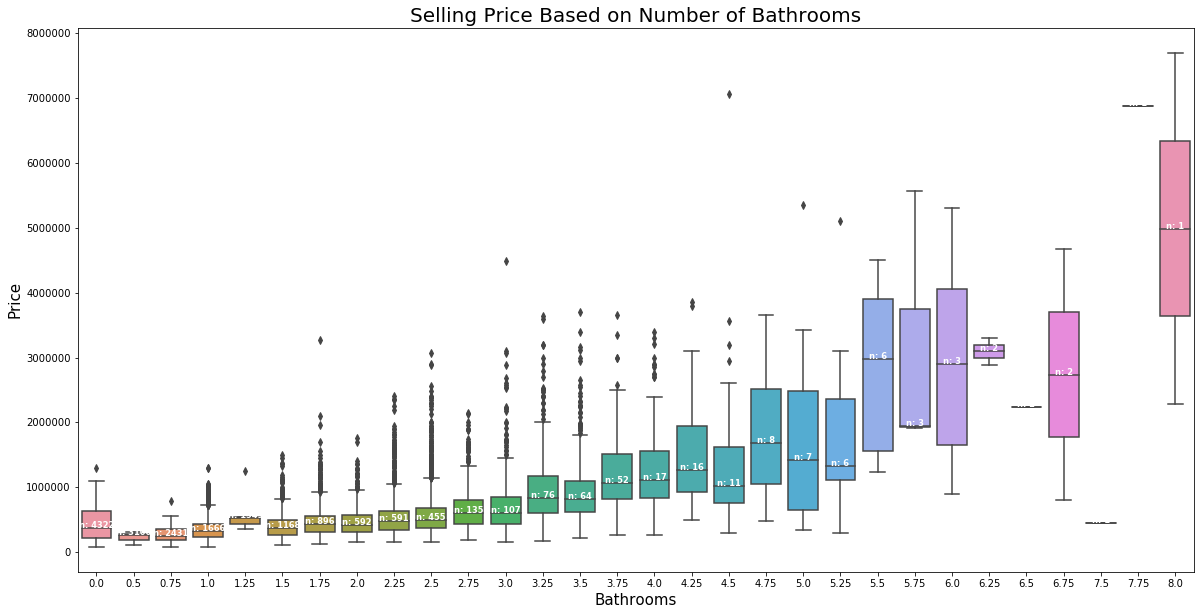

In [39]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df['bathrooms'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['bathrooms'])['price'].median().values
nobs = df['bathrooms'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Selling Price Based on Number of Bathrooms', size=20)
plt.ylabel('Price', size=15)
plt.xlabel('Bathrooms', size=15)

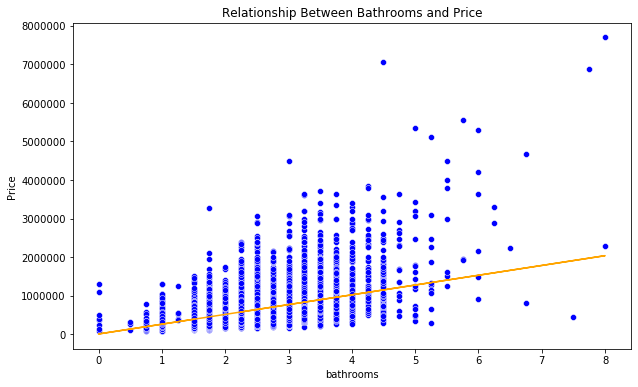

In [40]:
plt.subplots(figsize = (10,6))
ax = sns.scatterplot(x="bathrooms", y="price", data=df, color = 'blue')
ax.set(xlabel="bathrooms", ylabel = "Price", title="Relationship Between Bathrooms and Price")
x=df["bathrooms"]
y=df["price"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color = 'orange')

### 2. Grade - Construction Rating

Text(0.5, 0, 'Building and Construction Rating')

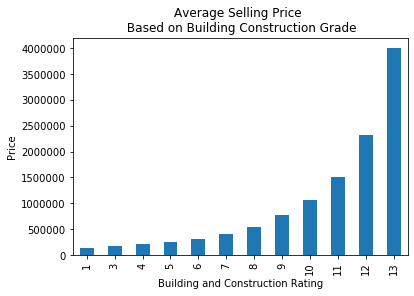

In [41]:
#Barplot Price v Grade
df.groupby('grade')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price \n Based on Building Construction Grade', size=12)
plt.ylabel('Price')
plt.xlabel('Building and Construction Rating')

### 3. Square Foot Living

In [42]:
df.sort_values('sqft_living')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,floors_x_sqft_living
10067,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850,9,290.0
7263,276000.0,1,0.75,370,1801,1.0,0,0,5,5,370,0,1923,0,98117,47.6778,-122.389,1340,5000,7,370.0
2430,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341,10,384.0
13989,228000.0,0,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000,10,390.0
6345,245000.0,1,1.00,390,2000,1.0,0,0,4,6,390,0,1920,0,98103,47.6938,-122.347,1340,5100,5,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15816,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454,6,9640.0
7519,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,9,19780.0
6903,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,6,20080.0
10366,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,10,30125.0


In [43]:
above_6std = df.price.mean()+(6*df.sqft_living.std())
above_6std

546259.6598772238

In [44]:
above_6std = df.price.mean()+(6*df.sqft_above.std())
above_6std

545715.1392829734

## Suprisingly weak correlations
- 'bedrooms', 'waterfront', 'view', 'condition', ('renovated_0' for later)

In [45]:
#Run below cell for pairplot

In [46]:
# sns.pairplot(df[['bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']], corner=True)
# plt.show()

## Bedrooms
poly3, cat, or normal?

Text(0.5, 0, 'Bedrooms')

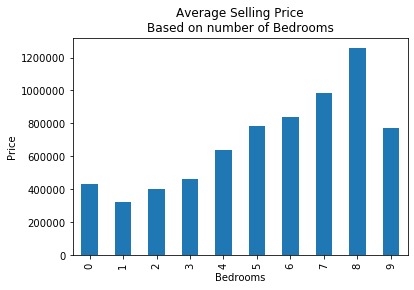

In [47]:
#Barplot Price v number of floors
df.groupby('bedrooms')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on number of Bedrooms', size=12)
plt.ylabel('Price')
plt.xlabel('Bedrooms')

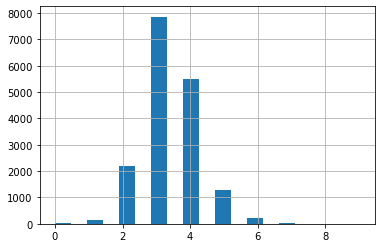

In [48]:
df.bedrooms.hist(bins=19)
plt.show()

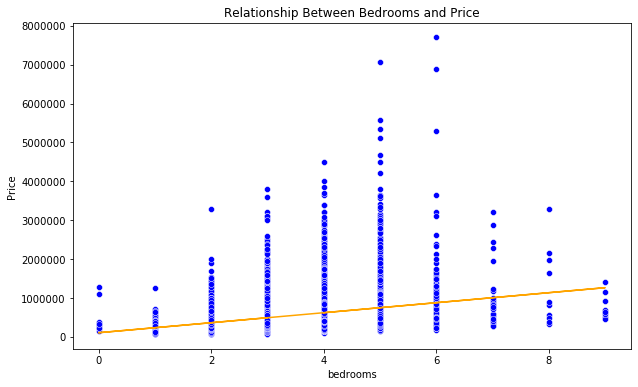

In [49]:
plt.subplots(figsize = (10,6))
ax = sns.scatterplot(x="bedrooms", y="price", data=df, color = 'blue')
ax.set(xlabel="bedrooms", ylabel = "Price", title="Relationship Between Bedrooms and Price")
x=df["bedrooms"]
y=df["price"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color = 'orange')

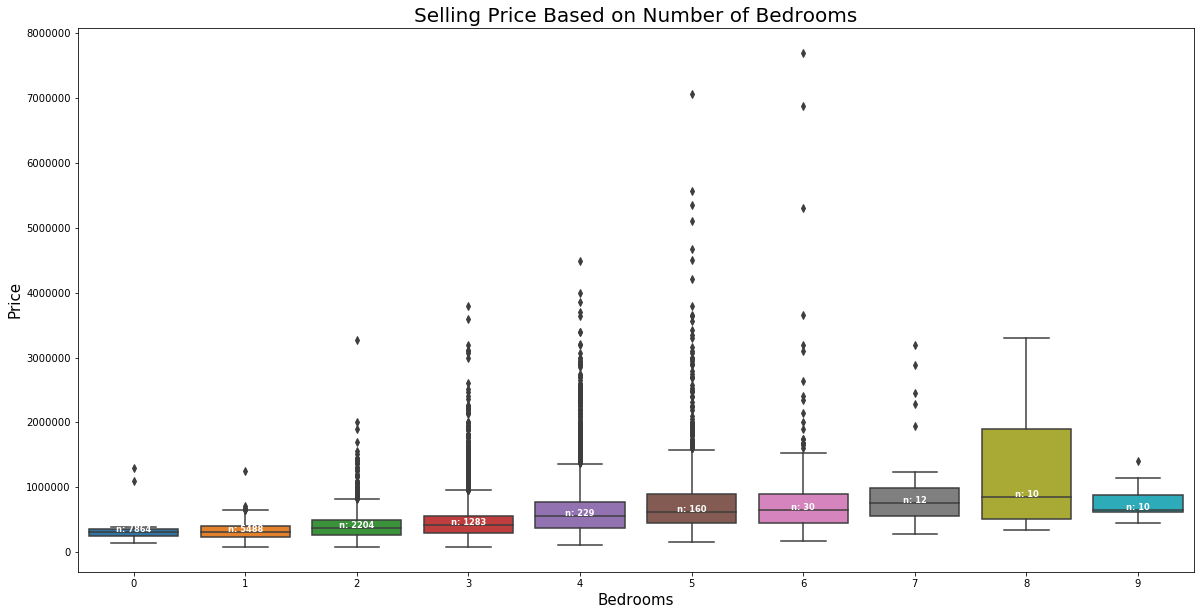

In [50]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df['bedrooms'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['bedrooms'])['price'].median().values
nobs = df['bedrooms'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Selling Price Based on Number of Bedrooms', size=20)
plt.ylabel('Price', size=15)
plt.xlabel('Bedrooms', size=15)

plt.show()

## Waterfront

Text(0.5, 0, 'Waterfront Property')

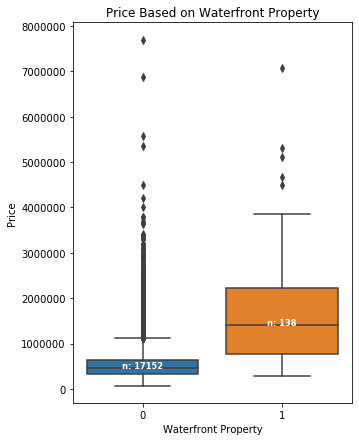

In [51]:
## Boxplot of Waterfront v. Price
plt.figure(figsize=(5,7))
ax = sns.boxplot(x=df['waterfront'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['waterfront'])['price'].median().values
nobs = df['waterfront'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Price Based on Waterfront Property')
plt.ylabel('Price')
plt.xlabel('Waterfront Property')

## Grade

Text(0.5, 0, 'Grade')

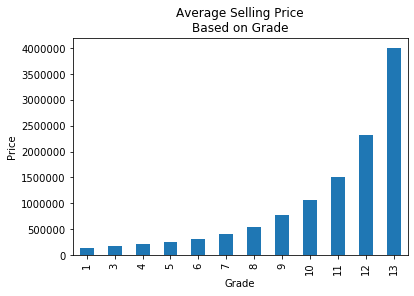

In [52]:
#Barplot Price v number of floors
df.groupby('grade')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on Grade', size=12)
plt.ylabel('Price')
plt.xlabel('Grade')

## View

Text(0.5, 0, 'View')

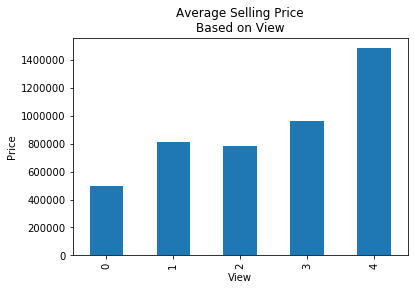

In [53]:
#Barplot Price v number of floors
df.groupby('view')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on View', size=12)
plt.ylabel('Price')
plt.xlabel('View')

Text(0.5, 0, 'View Rating')

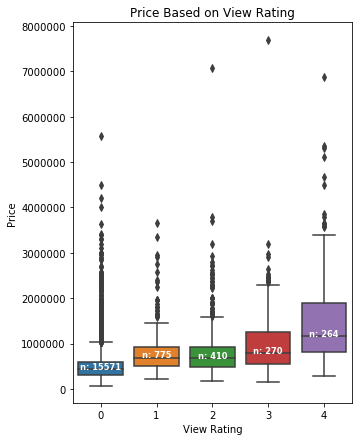

In [54]:
## Boxplot of View v. Price
plt.figure(figsize=(5,7))
ax = sns.boxplot(x=df['view'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['view'])['price'].median().values
nobs = df['view'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Price Based on View Rating')
plt.ylabel('Price')
plt.xlabel('View Rating')

## Condition

Text(0.5, 0, 'Condition')

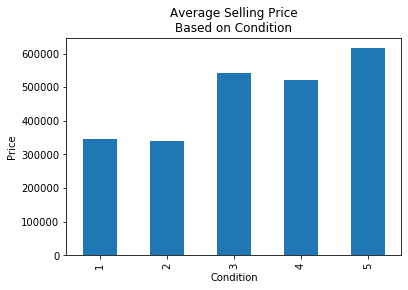

In [55]:
#Barplot Price v number of floors
df.groupby('condition')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on Condition', size=12)
plt.ylabel('Price')
plt.xlabel('Condition')

Text(0.5, 0, 'Condition Quality')

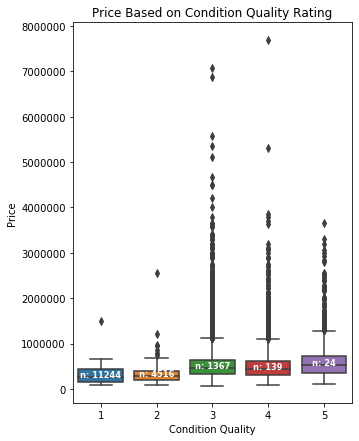

In [56]:
## Boxplot of Condition v. Price
plt.figure(figsize=(5,7))
ax = sns.boxplot(x=df['condition'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['condition'])['price'].median().values
nobs = df['condition'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
# Set labels
plt.title('Price Based on Condition Quality Rating')
plt.ylabel('Price')
plt.xlabel('Condition Quality')

In [57]:
# separate condition into 3 categories: 1/2, 3/4, and 5

# condition = [
#     (df.condition.values == 1) & (df.condition.values == 2),
#     (df.condition.values == 3) & (df.condition.values == 4),
#     (df.condition.values == 5)]

# choices = [
#     1, 
#     2, 
#     3,]

# df.conditions = np.select(conditions, choices, default='NA')

In [58]:
## RUN CELL ONCE
#Create dummy columns using 'condition2'
# df = pd.get_dummies(df, columns=['condition'])

# Step 3: Clean
- already took care of bedroom outliers with Read-In
- reining in square footage outliers
- work on binning 
    - `condition` into 3 categories: 1/2, 3/4, and 5
    - `view` into 3 categories: 0, 1&2, 3, 4 (or create poly?)

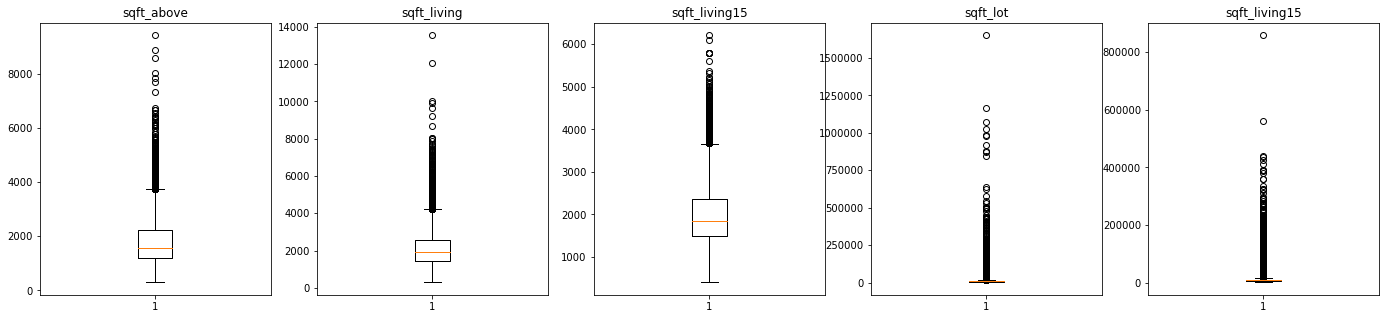

In [59]:
# Investigating Square footage outliers

plt.figure(figsize=(24,5))

ax3 = plt.subplot(1, 5, 1)
plt.boxplot(df.sqft_above)
ax3.set_title('sqft_above')

ax1 = plt.subplot(1, 5, 2)
plt.boxplot(df.sqft_living)
ax1.set_title('sqft_living')

ax2 = plt.subplot(1, 5, 3)
plt.boxplot(df.sqft_living15)
ax2.set_title('sqft_living15')


ax3 = plt.subplot(1, 5, 4)
plt.boxplot(df.sqft_lot)
ax3.set_title('sqft_lot')

ax3 = plt.subplot(1, 5, 5)
plt.boxplot(df.sqft_lot15)
ax3.set_title('sqft_living15')

plt.show()

In [60]:
# adjuting sqft home outliers to within 6 standard deviations of the mean
for col in ['sqft_above', 'sqft_living', 'sqft_living15']: 
    above_6std = df[col].mean()+(6*df[col].std())
    df[col] = np.where(df[col].values >above_6std, df[col].mean()+6*df[col].std(), df[col])
    
# adjusting lot outliers to within 9 standard deviations of the mean
for col in ['sqft_lot', 'sqft_lot15']: 
    above_9std = df[col].mean()+(9*df[col].std())
    df[col] = np.where(df[col].values >above_6std, df[col].mean()+9*df[col].std(), df[col])

# Try these to see if they improve model

In [61]:
# # Create Bins for Grade 1-4, 5-7, 8-13
# cut_labels1 = [1, 2, 3]
# cut_bins1 = [0, 4, 7, 13]
# df['cut_grade'] = pd.cut(df['grade'], bins=cut_bins1, labels=cut_labels1)
# df['cut_grade'] = pd.to_numeric(df['cut_grade'],errors='coerce')
# df = df.drop(['grade'], axis=1)

In [62]:
# # Create Bins for Condition 1-2, 3-4, 5
# cut_labels2 = [1, 2, 3]
# cut_bins2 = [0, 2, 4, 5]
# df['cut_condition'] = pd.cut(df['condition'], bins=cut_bins2, labels=cut_labels2)
# df['cut_condition'] = pd.to_numeric(df['condition'],errors='coerce')
# df = df.drop(['condition'], axis=1)

In [63]:
#Create dummy columns of 'view' - Trying this in 2.2 instead of binning condition in 2.1
df = pd.get_dummies(df, columns=['condition'], drop_first=True)

In [64]:
#Create dummy columns of 'view'
df = pd.get_dummies(df, columns=['view'], drop_first=True)

In [65]:
#Create dummy columns of 'floors'
df = pd.get_dummies(df, columns=['floors'], drop_first=True)

# Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

# Create new features with lat/long here!!

In [66]:
## RUN THIS CELL ONLY ONCE!

#Create new column 'age' for age of house
df['age'] = 2015 - df.yr_built

#Create dummy variable 'basement' y/n
df['basement'] = np.where(df['sqft_basement']>0 , 1, 0)
df = pd.get_dummies(df, columns=['basement'])
df = df.drop(['basement_0'], axis=1)

#Create a new column 'neighbors_compared' with sqft_living - sqft_living15
df['neighbors_compared'] = df.sqft_living - df.sqft_living15

#Create dummy columns using 'nc_2'
df['nc2'] = np.where(df['sqft_living']> df['sqft_living15'] , 1, 0)
df = pd.get_dummies(df, columns=['nc2'])
df = df.drop(['nc2_0'], axis=1)


Playing with `renovated` columns:

In [67]:
#RUN CELL ONLY ONCE

#Create new column 'last_renovted' for how long ago since last renovation
df['last_ren'] = np.where(df['yr_renovated'] > 0, (2015 - df['yr_renovated']), 0)


#Create new column 'last_ren2' for how long (years) since last renovation and including age if no renovation
df['last_ren2'] = np.where(df['yr_renovated'] > 0, (2015 - df['yr_renovated']), (2015 - df['yr_built']))

#Create dummy columns using 'renovated'
df['renovated'] = np.where(df['yr_renovated']>0 , 1, 0)
df = pd.get_dummies(df, columns=['renovated'], drop_first=True)


In [68]:

df = df.drop(['yr_built'], axis=1)
df = df.drop(['yr_renovated'], axis=1)

#### Create dummy zip codes

In [69]:
# Create dummy variables for zipcodes
zip_dummies = pd.get_dummies(df['zipcode'].astype(str), drop_first=True)
#df.drop(columns=['zipcode'],inplace=True)
#zips = 'zip'+zip_dummies.columns
# zip_dummies.columns = zips
# zip_dummies.head()
df.drop('zipcode',axis=1,inplace=True)

## Checking on new features

In [70]:
#Run below cell for correlation matrix

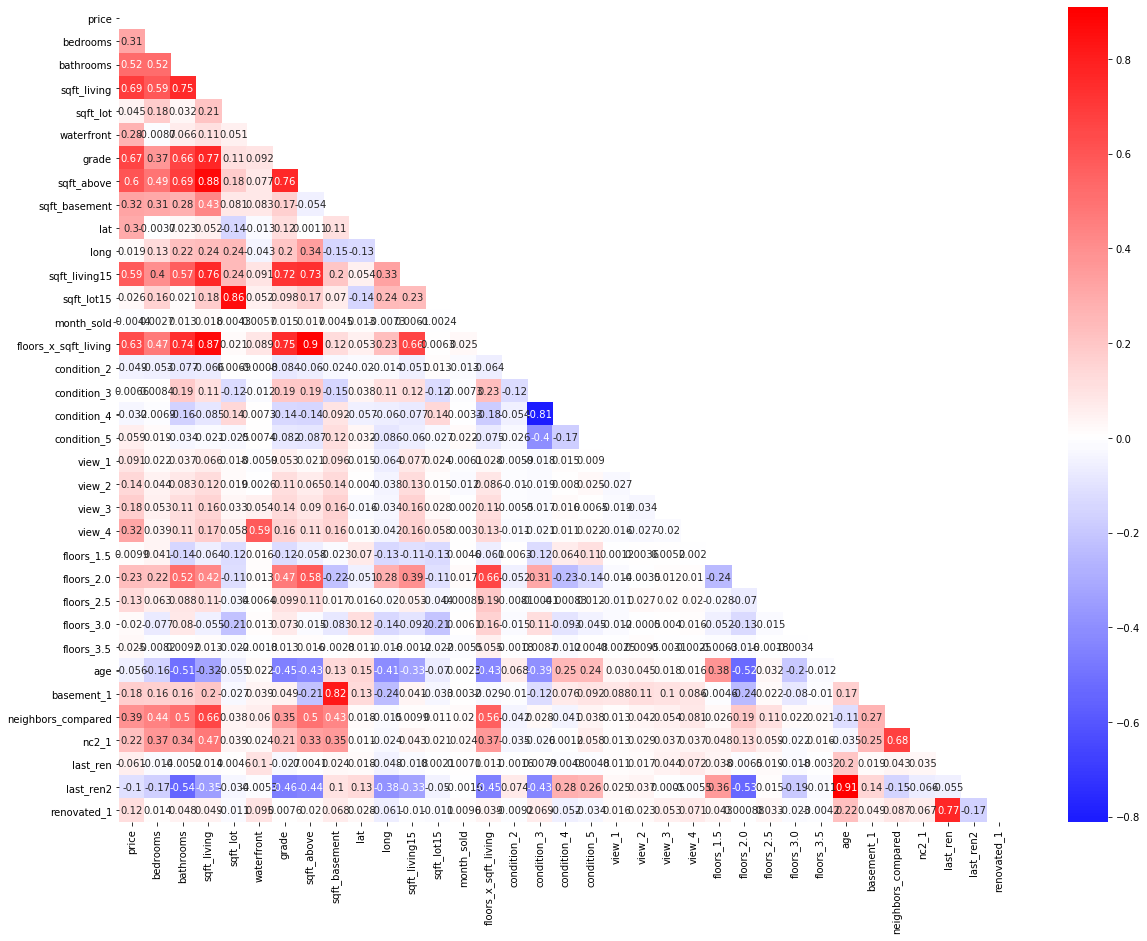

In [71]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(20, 15))

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [72]:
df.head(20)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,month_sold,floors_x_sqft_living,condition_2,condition_3,condition_4,condition_5,view_1,view_2,view_3,view_4,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,age,basement_1,neighbors_compared,nc2_1,last_ren,last_ren2,renovated_1
0,365000.0,4,2.25,2070.0,395985.013979,0,8,2070.0,0,47.4388,-122.162,2390.0,257920.414075,10,4140.0,0,0,1,0,0,0,0,0,0,1,0,0,0,29,0,-320.0,0,0,29,0
1,865000.0,5,3.00,2900.0,395985.013979,0,8,1830.0,1070,47.6784,-122.285,2370.0,257920.414075,8,2900.0,0,0,0,1,0,0,0,0,0,0,0,0,0,38,1,530.0,1,0,38,0
2,1038000.0,4,2.50,3770.0,395985.013979,0,11,3770.0,0,47.5646,-122.129,3710.0,257920.414075,8,7540.0,0,1,0,0,0,1,0,0,0,1,0,0,0,18,0,60.0,1,0,18,0
3,1490000.0,3,3.50,4560.0,395985.013979,0,12,4560.0,0,47.6995,-122.228,4050.0,257920.414075,3,9120.0,0,1,0,0,0,1,0,0,0,1,0,0,0,25,0,510.0,1,0,25,0
4,711000.0,3,2.50,2550.0,5376.000000,0,9,2550.0,0,47.6647,-122.083,2250.0,4050.000000,7,5100.0,0,1,0,0,0,0,0,0,0,1,0,0,0,11,0,300.0,1,0,11,0
5,211000.0,4,2.00,1710.0,395985.013979,0,7,1710.0,0,47.3947,-122.174,1710.0,257920.414075,8,2565.0,0,1,0,0,0,0,0,0,1,0,0,0,0,45,0,0.0,0,0,45,0
6,790000.0,4,2.50,2690.0,395985.013979,0,9,2690.0,0,47.6596,-122.144,2420.0,257920.414075,8,5380.0,0,0,1,0,0,0,0,0,0,1,0,0,0,28,0,270.0,1,0,28,0
7,680000.0,3,2.50,1800.0,4400.000000,0,7,1350.0,450,47.6599,-122.396,1920.0,4400.000000,10,1800.0,0,0,0,1,0,0,0,0,0,0,0,0,0,45,1,-120.0,0,0,45,0
8,384500.0,3,2.50,1600.0,2610.000000,0,8,1600.0,0,47.5344,-122.068,1445.0,1288.000000,8,3200.0,0,1,0,0,0,0,0,0,0,1,0,0,0,10,0,155.0,1,0,10,0
9,605000.0,2,1.00,910.0,3600.000000,0,7,910.0,0,47.6341,-122.361,1720.0,3600.000000,5,910.0,0,0,1,0,0,0,0,0,0,0,0,0,0,106,0,-810.0,0,0,106,0


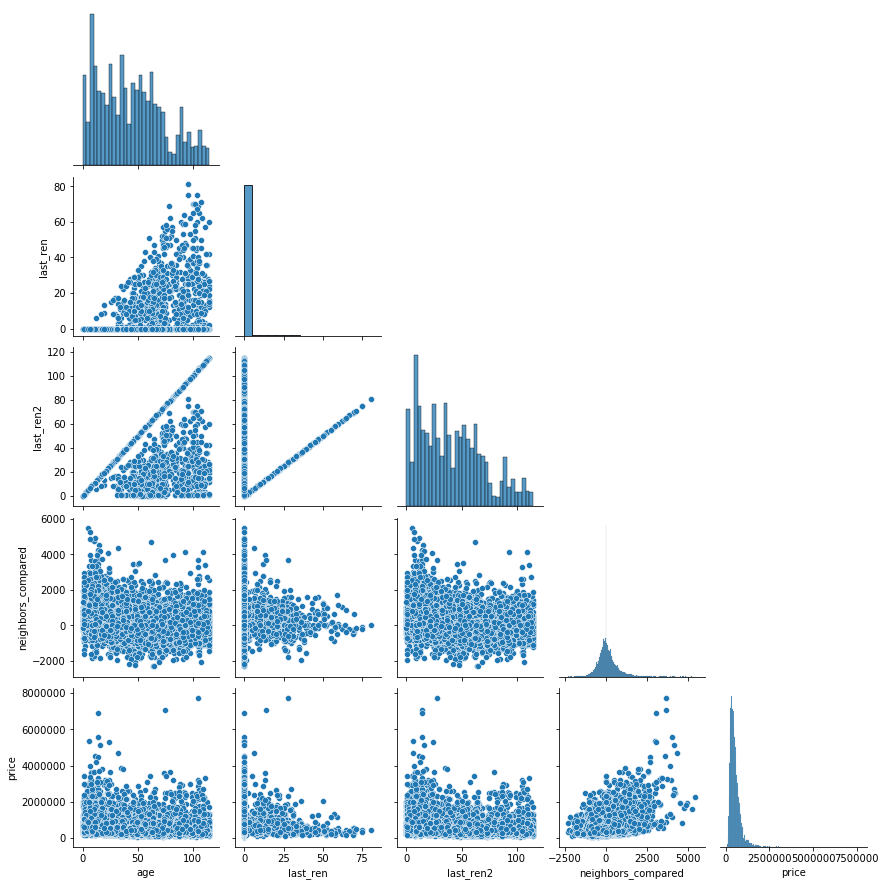

In [73]:
#Checking on new features
sns.pairplot(df[['age', 'last_ren', 'last_ren2', 'neighbors_compared', 'price']], corner=True)


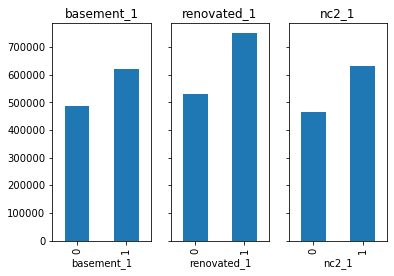

In [74]:
# Create bar plots

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

categoricals = ['basement_1', 'renovated_1', 'nc2_1',]

for col, ax in zip(categoricals, axes.flatten()):
    (df.groupby(col).mean()['price']
         .sort_values()              # sort the groups in ascending order if desired
         .plot.bar(ax=ax))
    ax.set_title(col)
#fig.tight_layout()

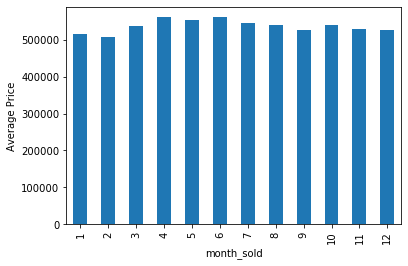

In [75]:
#zip_means = df.groupby(['zipcode']).price.mean().sort_values(ascending=False)
plt.figure()
plt.ylabel('Average Price')
(df.groupby(['month_sold']).price.mean()).plot(kind='bar')



In [76]:
#Drop unwanted columns with multicollinearity
to_drop = ['last_ren',
          'month_sold',
          'nc2_1']
df = df.drop(to_drop, axis=1)

In [77]:
# # Concat df and zip dummies DFs
# df = pd.concat([df, zip_dummies], axis=1)

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

In [78]:
#df.head() # Sanity Check to remove dummy variables

In [79]:
list(df.iloc[:,1:])

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'floors_x_sqft_living',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'age',
 'basement_1',
 'neighbors_compared',
 'last_ren2',
 'renovated_1']

In [80]:
# list_features = list(df.iloc[:,1:])
# df_features = df[features]
# target = df['price']

In [81]:
# your code here
poly_cols = ['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'floors_x_sqft_living',
 'age',
 'neighbors_compared',
 'last_ren2',]

In [82]:
#poly2_features = pd.DataFrame()
df_poly3_features = pd.DataFrame()

# for feat in poly_cols:
#     poly2_features[feat+'^2'] = df[feat]**2
for feat in poly_cols:    
    df_poly3_features[feat+'^3'] = df[feat]**3

In [83]:
df_poly3_features.head()

,bedrooms^3,bathrooms^3,sqft_living^3,sqft_lot^3,grade^3,sqft_above^3,sqft_basement^3,lat^3,long^3,sqft_living15^3,sqft_lot15^3,floors_x_sqft_living^3,age^3,neighbors_compared^3,last_ren2^3
0,64,11.390625,8.869743e+09,6.209209e+16,512,8.869743e+09,0,106758.160996,-1.823091e+06,1.365192e+10,1.715762e+16,7.095794e+10,24389,-32768000.0,24389
1,125,27.000000,2.438900e+10,6.209209e+16,512,6.128487e+09,1225043000,108383.960963,-1.828604e+06,1.331205e+10,1.715762e+16,2.438900e+10,54872,148877000.0,54872
2,64,15.625000,5.358263e+10,6.209209e+16,1331,5.358263e+10,0,107609.731195,-1.821614e+06,5.106481e+10,1.715762e+16,4.286611e+11,5832,216000.0,5832
3,27,42.875000,9.481882e+10,6.209209e+16,1728,9.481882e+10,0,108527.920101,-1.826048e+06,6.643012e+10,1.715762e+16,7.585505e+11,15625,132651000.0,15625
4,27,15.625000,1.658138e+10,1.553738e+11,729,1.658138e+10,0,108290.558060,-1.819557e+06,1.139062e+10,6.643012e+10,1.326510e+11,1331,27000000.0,1331


### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [84]:
# binary_vars = 
# continuous_vars = 

In [85]:
# your code here

# Step 5: Train-Test Split

### 5.1) Perform a train-test split of the data.

This code will need to be re-run with list(df.columns) if features are added

In [86]:
# df.head() #Sanity Check

In [87]:
# features = df_zips.iloc[:,1:]
# features

In [88]:
# Concat DFs together
df_zips = pd.concat([df, zip_dummies], axis=1)

In [89]:
df_zips = df_zips.iloc[:,1:]
target = df['price']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(df_zips, target, random_state=42,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (13832, 100) Target:  (13832,)
Training set - Features:  (3458, 100) Target:  (3458,)


In [91]:
# #Checking VIF
# from statsmodels.stats.outliers_influence import variance_inflation_factor


# [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
# vif["features"] = df.columns
# vif.round(1)
# #vif.sort_values(by='VIF Factor', ascending=False)

In [92]:
#instantiate and fit
lm = LinearRegression()
lm = lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

#Evaluate
test_mae = metrics.mean_absolute_error(y_test, y_pred) # <-----
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) # <-----

print('Simple Model RMSE:' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Simple Model RMSE:150972.59068705127


In [93]:
df_zips

,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,floors_x_sqft_living,condition_2,condition_3,condition_4,condition_5,view_1,view_2,view_3,view_4,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,age,basement_1,neighbors_compared,last_ren2,renovated_1,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,4,2.25,2070.0,395985.013979,0,8,2070.0,0,47.4388,-122.162,2390.0,257920.414075,4140.0,0,0,1,0,0,0,0,0,0,1,0,0,0,29,0,-320.0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,3.00,2900.0,395985.013979,0,8,1830.0,1070,47.6784,-122.285,2370.0,257920.414075,2900.0,0,0,0,1,0,0,0,0,0,0,0,0,0,38,1,530.0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,2.50,3770.0,395985.013979,0,11,3770.0,0,47.5646,-122.129,3710.0,257920.414075,7540.0,0,1,0,0,0,1,0,0,0,1,0,0,0,18,0,60.0,18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,3.50,4560.0,395985.013979,0,12,4560.0,0,47.6995,-122.228,4050.0,257920.414075,9120.0,0,1,0,0,0,1,0,0,0,1,0,0,0,25,0,510.0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,2.50,2550.0,5376.000000,0,9,2550.0,0,47.6647,-122.083,2250.0,4050.000000,5100.0,0,1,0,0,0,0,0,0,0,1,0,0,0,11,0,300.0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5,2.50,3240.0,395985.013979,0,8,2020.0,1220,47.5858,-122.112,2730.0,257920.414075,3240.0,0,1,0,0,1,0,0,0,0,0,0,0,0,57,1,510.0,57,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17286,2,1.75,1300.0,4000.000000,0,7,1300.0,0,47.6687,-122.288,1350.0,4013.000000,2600.0,0,1,0,0,0,0,0,0,0,1,0,0,0,67,0,-50.0,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17287,3,1.00,1050.0,395985.013979,0,7,1050.0,0,47.7635,-122.262,1760.0,257920.414075,1050.0,0,1,0,0,0,0,0,0,0,0,0,0,0,62,0,-710.0,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17288,3,1.50,1900.0,395985.013979,0,7,1300.0,600,47.4199,-121.990,2080.0,257920.414075,2850.0,0,0,1,0,0,0,0,0,1,0,0,0,0,44,1,-180.0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Log
after edits:
- LOG Training RMSE: 133061
- LOG Testing RMSE:  134488

In [94]:
y_log = np.log(y_train)

# instantiate a linear regression object and fit
lm_log = LinearRegression()
lm_log = lm_log.fit(X_train, y_log)

In [95]:
log_train_pred = lm_log.predict(X_train)

# exponentiate the predictions to get them on the same original scale 
y_train_pred = np.exp(log_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('LOG Training Root Mean Squared Error:' , train_rmse)

LOG Training Root Mean Squared Error: 133061.38373114888


In [96]:
log_test_pred = lm_log.predict(X_test)

# exponentiate the predictions to get them on the same original scale 
log_test_pred = np.exp(log_test_pred)
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, log_test_pred))

print('LOG Training RMSE:' , int(train_rmse))
print('LOG Testing RMSE: ' , int(log_test_rmse))

LOG Training RMSE: 133061
LOG Testing RMSE:  134488


In [97]:
# Checking mae vs rmse
metrics.mean_absolute_error(y_train, y_train_pred) 

75636.60259379863

In [98]:
#If we decide to use Log, run this cell!!

# reassign y_test_pred to our log model
y_test_pred = lm_log.predict(X_test)

#our model predicted the log of gross, so now we must exponentiate to get value back in $
y_test_pred = np.exp(y_test_pred)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

#print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  133061 vs. Testing:  134488


Now let's use those selected features to fit a model.

# Polynomial Features

## Poly 2

#### with Log, no feature selection
- Training RMSE:  151,662
- Testing RMSE: 528,977

after zips
- Training RMSE: 79,093
- **Testing RMSE: 138,793 *Best**

#### Poly with Log and Kbest (83 features)
- KBEST Training RMSE: 171,302
- KBEST Testing RMSE: 170,581

#### Poly with Log and RFE (after zips)
- RFE Training RMSE: 179,763
- RFE Testing RMSE: 170,627

##### Creating poly2 features with log, before feature selection

In [137]:
#list(df_zips.columns)

In [100]:
poly_features = df_zips
target = df['price']

In [101]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(poly_features)
poly2_columns = poly_2.get_feature_names(poly_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
#df_poly2.head() #Sanity Check

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=42,test_size=0.2)

In [103]:
# instantiate a linear regression object and fit to training data
lm_2 = LinearRegression()
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 96415.65976468431


In [104]:
# use fitted model to predict on test data
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 3517252.1956386357
Training:  96415 vs. Testing:  3517252


##### KBest
after binning/dummies, with log:
33 variables
- KBEST Training 120542
- KBEST Testing RMSE: 111164

20 variables
- Training Root Mean Squared Error: 192118
- Testing Root Mean Squared Error: 187339

83 variables
- KBEST Training Root Mean Squared Error: 171302
- KBEST Testing Root Mean Squared Error: 170581

Note: Run KBest without Log?

##### Poly2 log, KBest 500 features
- KBEST Training RMSE: 119220
- KBEST Testing RMSE: 146641

KBest 83
- KBEST Training Root Mean Squared Error: 171302
- KBEST Testing Root Mean Squared Error: 170581

did worse after zips added (28 features):
- KBEST Training Root Mean Squared Error: 193908
- KBEST Testing Root Mean Squared Error: 187826

In [105]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=200) # <----- number of features you want
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()] #kept columns
removed_columns = X_train.columns[~selector.get_support()] #removed columns
#list(selected_columns)
#list(removed_columns)

In [106]:
len(selected_columns)

200

In [107]:
#instantiate a linear regression object and fit to train data
lm_kbest = LinearRegression()
lm_kbest.fit(X_train[selected_columns], y_train)

# Training Root Mean Squared Error
y_train_kbest = lm_kbest.predict(X_train[selected_columns])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
print('KBEST Training RMSE:' , int(trainK_rmse))

# Testing Root Mean Squared Error
y_kbest = lm_kbest.predict(X_test[selected_columns])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
print('KBEST Testing RMSE:' , int(testK_rmse))

KBEST Training RMSE: 141042
KBEST Testing RMSE: 286420


##### RFE with Log
- Training RMSE: 201,630
- Testing RMSE: 197,283

after zips
- Training RMSE: 179,763
- Testing RMSE: 170,627

Kbest 200, RFE 72
- Training RMSE: 159830
- Testing RMSE: 152319


In [108]:
# X_train = X_train[selected_columns]
# X_train.shape

In [109]:
# from sklearn.feature_selection import RFECV

# ols = linear_model.LinearRegression()

# selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# # Fit recursive feature eliminator 
# selector.fit(X_train, y_train)

In [110]:
# selected_rfe = X_train.columns[selector.support_]
# removed_rfe = X_train.columns[~selector.support_]
# # list(selected_rfe)
# # list(removed_rfe)

In [111]:
# #instantiate a linear regression object and fit to train
# lm_rfe = LinearRegression()
# lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

# # Train
# y_rfe = lm_rfe.predict(X_train[selected_rfe])
# trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
# print('Training RMSE:' , trainRFE_rmse)

# # Test
# y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
# testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
# print('Testing Root Mean Squared Error:' , testRFE_rmse)

In [112]:
# X_test[selected_rfe].shape
# list(X_test[selected_rfe])

## Poly 3
performs worse than Poly2

#### Poly3 RFE
400 kbest, 146 rfe
- Training Root Mean Squared Error: 149175
- Testing Root Mean Squared Error: 148917

#### Poly3 Log and KBest (86 features) *best before zips?
- KBEST Training RMSE: 170993
- KBEST Testing RMSE: 169767

after adding zips:
- KBEST Training RMSE 193787
- KBEST Testing RMSE: 187970

In [113]:
# poly_3 = PolynomialFeatures(degree=3, include_bias=False)
# poly3_data = poly_3.fit_transform(df_zips)
# poly3_columns = poly_3.get_feature_names(df_zips.columns)
# df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
# #df_poly3.head()

In [114]:
# df_poly3.shape

In [115]:
# df_poly3 = df_poly2.iloc[:, :-2415]
# df_poly3.head()

In [116]:
# # Concat dfs together to test
# df_poly3 = pd.concat([df_poly3, zip_dummies], axis=1)
# #df_poly3.head()

In [117]:
# #Split
# lm_3 = LinearRegression()
# lm_3 = lm_3.fit(df_poly3, target)

# X_train, X_test, y_train, y_test = train_test_split(df_poly3, target, random_state=42,test_size=0.2)

# #check the shape of the results
# print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
# print("Testing set - Features: ", X_test.shape, "Test: ",y_test.shape)

In [118]:
# #Train
# #instantiate and fit
# lm = LinearRegression()
# lm = lm.fit(X_train, y_train) # <-----
# y_train_pred = lm.predict(X_train)

# train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
# print('Poly3 Train RMSE:' , train_rmse)

In [119]:
# #TEST
# y_pred = lm.predict(X_test)
# test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) # <-----

# print('Mean Absolute Error:' + str(metrics.mean_absolute_error(y_test, y_pred))) 
# # print('Mean Squared Error:' + str(metrics.mean_squared_error(y_test, y_pred)))
# print('Poly3 Train RMSE:' , int(train_rmse))
# print('Poly3 Test RMSE:' , int(test_rmse))

##### Poly3 KBest

In [120]:
# from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

# selector = SelectKBest(f_regression, k=400) # <----- f_regression and number of features you want
# selector.fit(X_train, y_train)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns
# # list(selected_columns)
# # len(removed_columns)

In [121]:
# #instantiate a linear regression object and fit to train data
# lm_kbest = LinearRegression()
# lm_kbest.fit(X_train[selected_columns], y_train)

# # Training Root Mean Squared Error
# y_train_kbest = lm_kbest.predict(X_train[selected_columns])
# trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
# print('KBEST Training RMSE:' , int(trainK_rmse))

# # Testing Root Mean Squared Error
# y_kbest = lm_kbest.predict(X_test[selected_columns])
# testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
# print('KBEST Testing RMSE:' , int(testK_rmse))

In [122]:
# X_train = X_train[selected_columns]

##### Poly3 RFE
400 kbest, 146 rfe
- Training Root Mean Squared Error: 149175
- Testing Root Mean Squared Error: 148917

In [123]:
# Run below cells only if you want computer to crash!:)

In [124]:
# from sklearn.feature_selection import RFECV
# ols = linear_model.LinearRegression()

# selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# # Fit recursive feature eliminator 
# selector.fit(X_train, y_train)

In [125]:
# selected_rfe = X_train.columns[selector.support_]
# removed_rfe = X_train.columns[~selector.support_]
# # list(selected_rfe)
# # list(removed_rfe)

In [126]:
# #instantiate a linear regression object and fit to train
# lm_rfe = LinearRegression()
# lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

# # Train
# y_rfe = lm_rfe.predict(X_train[selected_rfe])
# trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
# print('Training Root Mean Squared Error:' , trainRFE_rmse)

# # Test
# y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
# testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
# print('Testing Root Mean Squared Error:' , testRFE_rmse)

In [127]:
# X_train[selected_rfe].shape

# Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

## Lasso

In [128]:
# ## training the model
# from sklearn.linear_model import Lasso

# lasso = Lasso(alpha=.1, normalize=False)

# lasso.fit(X_train,y_train)

# y_train_pred_lasso = lasso.predict(X_train)
# y_pred_lasso = lasso.predict(X_test)

# train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
# test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
# print('Training Error: '+ str(train_rmse_lasso01) )
# print('Testing Error: '+ str(test_rmse_lasso01) )

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [129]:
# your code here

# Step 7: Evaluate your different models in order to determine the best model overall.

# Step 8:  Refit your best model to the entire dataset.

In [130]:
# # Poly2 model
# selector = SelectKBest(f_regression, k=83) # <----- number of features you want
# selector.fit(df_poly2, target)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns

In [131]:
# # Poly3 model
# selector = SelectKBest(f_regression, k=86) # <----- f_regression and number of features you want
# selector.fit(df_poly3, target)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns

In [132]:
#instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm_final.fit(df_poly2[selected_columns], target)

In [133]:
list(selected_columns)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_living15',
 'floors_x_sqft_living',
 'view_4',
 'floors_2.0',
 'neighbors_compared',
 '98004',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms sqft_living',
 'bedrooms waterfront',
 'bedrooms grade',
 'bedrooms sqft_above',
 'bedrooms sqft_basement',
 'bedrooms lat',
 'bedrooms long',
 'bedrooms sqft_living15',
 'bedrooms floors_x_sqft_living',
 'bedrooms view_4',
 'bedrooms floors_2.0',
 'bedrooms basement_1',
 'bedrooms neighbors_compared',
 'bedrooms 98004',
 'bedrooms 98039',
 'bathrooms^2',
 'bathrooms sqft_living',
 'bathrooms sqft_lot',
 'bathrooms waterfront',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_basement',
 'bathrooms lat',
 'bathrooms long',
 'bathrooms sqft_living15',
 'bathrooms sqft_lot15',
 'bathrooms floors_x_sqft_living',
 'bathrooms view_3',
 'bathrooms view_4',
 'bathrooms floors_2.0',
 'bathrooms age',
 'bathrooms basement_1',


## Checking model attributes to copy to holdout notebook

In [134]:
list(df_poly2[selected_columns].columns)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_living15',
 'floors_x_sqft_living',
 'view_4',
 'floors_2.0',
 'neighbors_compared',
 '98004',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms sqft_living',
 'bedrooms waterfront',
 'bedrooms grade',
 'bedrooms sqft_above',
 'bedrooms sqft_basement',
 'bedrooms lat',
 'bedrooms long',
 'bedrooms sqft_living15',
 'bedrooms floors_x_sqft_living',
 'bedrooms view_4',
 'bedrooms floors_2.0',
 'bedrooms basement_1',
 'bedrooms neighbors_compared',
 'bedrooms 98004',
 'bedrooms 98039',
 'bathrooms^2',
 'bathrooms sqft_living',
 'bathrooms sqft_lot',
 'bathrooms waterfront',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_basement',
 'bathrooms lat',
 'bathrooms long',
 'bathrooms sqft_living15',
 'bathrooms sqft_lot15',
 'bathrooms floors_x_sqft_living',
 'bathrooms view_3',
 'bathrooms view_4',
 'bathrooms floors_2.0',
 'bathrooms age',
 'bathrooms basement_1',


In [135]:
len(lm_final.coef_)

200

# Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [136]:
import pickle

#Model
pickle_out = open("poly2_model2.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()